Cell Nuclei Separation — Watershed
Task: Separate touching nuclei.

Methods: Marker-controlled watershed.

Dataset: Kaggle — Data Science Bowl Cell Nuclei.

Compare: With vs. without markers.

Learning: Over-segmentation control.

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label

In [6]:
train_path = "dataset"
sample_id = os.listdir(train_path)[0]

img_path = os.path.join(train_path, sample_id, "images", sample_id + ".png")
mask_dir = os.path.join(train_path, sample_id, "masks")

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# combine all masks into ground truth
gt_mask = np.zeros(img.shape[:2], dtype=np.uint8)

for m in os.listdir(mask_dir):
    m_img = cv2.imread(os.path.join(mask_dir, m), 0)
    gt_mask = np.maximum(gt_mask, m_img)

_, gt_mask = cv2.threshold(gt_mask, 0, 255, cv2.THRESH_BINARY)

In [7]:
kernel = np.ones((3,3), np.uint8)

opening = cv2.morphologyEx(gt_mask, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(dist, 0.4*dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), markers)

pred_mask = np.zeros_like(gt_mask)
pred_mask[markers > 1] = 255   # segmented nuclei

In [8]:
def dice_score(gt, pred):
    gt = gt > 0
    pred = pred > 0
    intersection = np.logical_and(gt, pred).sum()
    return 2 * intersection / (gt.sum() + pred.sum())

# object counts
gt_labels = label(gt_mask)
pred_labels = label(pred_mask)

true_objects = gt_labels.max()
pred_objects = pred_labels.max()

# over & under segmentation
over_seg = max(pred_objects - true_objects, 0) / true_objects
under_seg = max(true_objects - pred_objects, 0) / true_objects

dice = dice_score(gt_mask, pred_mask)


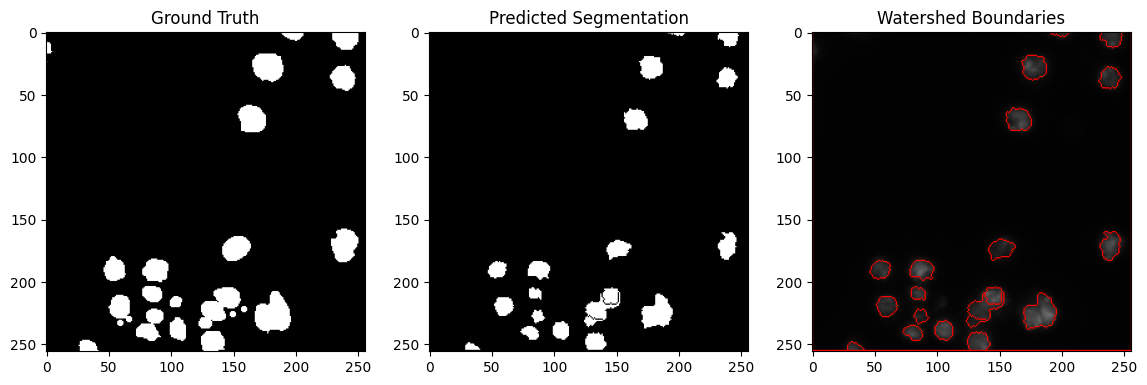

In [9]:
result = img.copy()
result[markers == -1] = [255,0,0]

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.title("Ground Truth")
plt.imshow(gt_mask, cmap='gray')

plt.subplot(1,3,2)
plt.title("Predicted Segmentation")
plt.imshow(pred_mask, cmap='gray')

plt.subplot(1,3,3)
plt.title("Watershed Boundaries")
plt.imshow(result)

plt.show()

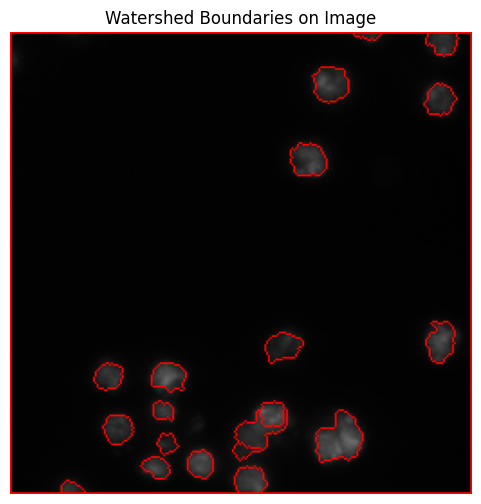

In [12]:
overlay = img.copy()
overlay[markers == -1] = [255, 0, 0]  # watershed boundaries in red

plt.figure(figsize=(6,6))
plt.title("Watershed Boundaries on Image")
plt.imshow(overlay)
plt.axis('off')
plt.show()

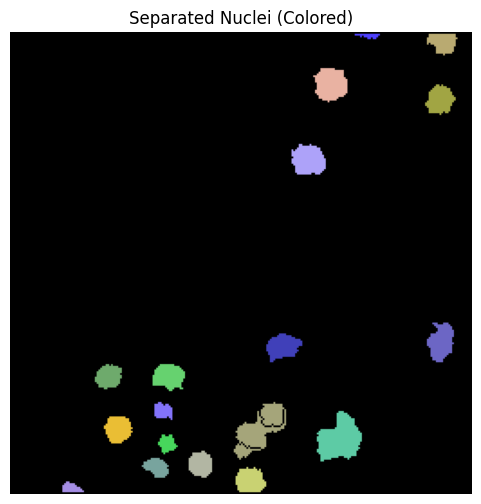

In [14]:
colored = np.zeros((*pred_mask.shape, 3), dtype=np.uint8)

for i in range(1, pred_objects + 1):
    colored[pred_labels == i] = np.random.randint(50,255,3)

plt.figure(figsize=(6,6))
plt.title("Separated Nuclei (Colored)")
plt.imshow(colored)
plt.axis('off')
plt.show()

In [10]:
print("===== SEGMENTATION METRICS =====")
print(f"True nuclei count: {true_objects}")
print(f"Predicted nuclei count: {pred_objects}")
print(f"Dice Score: {dice:.4f}")
print(f"Over-Segmentation Score: {over_seg:.4f}")
print(f"Under-Segmentation Score: {under_seg:.4f}")

===== SEGMENTATION METRICS =====
True nuclei count: 23
Predicted nuclei count: 18
Dice Score: 0.7481
Over-Segmentation Score: 0.0000
Under-Segmentation Score: 0.2174


In [11]:

def iou_score(gt, pred):
    gt = gt > 0
    pred = pred > 0
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    return intersection / union

def precision_recall(gt, pred):
    gt = gt > 0
    pred = pred > 0

    TP = np.logical_and(gt, pred).sum()
    FP = np.logical_and(~gt, pred).sum()
    FN = np.logical_and(gt, ~pred).sum()

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)

    return precision, recall

# IoU
iou = iou_score(gt_mask, pred_mask)

# Precision & Recall
precision, recall = precision_recall(gt_mask, pred_mask)

# F1 Score
f1 = 2 * precision * recall / (precision + recall + 1e-6)

# nucleus area analysis
gt_areas = [np.sum(gt_labels == i) for i in range(1, true_objects+1)]
pred_areas = [np.sum(pred_labels == i) for i in range(1, pred_objects+1)]

print("\n===== ADVANCED METRICS =====")
print(f"IoU Score: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Average GT nucleus area: {np.mean(gt_areas):.1f}")
print(f"Average Pred nucleus area: {np.mean(pred_areas):.1f}")


===== ADVANCED METRICS =====
IoU Score: 0.5976
Precision: 0.9968
Recall: 0.5988
F1 Score: 0.7481
Average GT nucleus area: 248.5
Average Pred nucleus area: 190.7
